
 ## palm_reconstruction.ipynb

 Copyright © 2023-2025 Biteen Lab (University of Michigan)
 SPDX-License-Identifier: GPL-3.0-or-later

 This program is free software: you can redistribute it and/or modify
 it under the terms of the GNU General Public License as published by
 the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 This program is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU General Public License for more details.

 You should have received a copy of the GNU General Public License
 along with this program (LICENSE file in the repository root).
 If not, see <https://www.gnu.org/licenses/>.


### Reconstructs a PALM super‑resolution image from single‑molecule localizations

#### Workflow
1. **Input discovery**  – Collect phase contrast image, corresponding
   localization `*fits.csv`, and `PhaseMask.tif`.
2. **Localisation parsing** – Read CSVs into pandas, filter rows by
   `goodfit==1` and a localization precision threshold (`widthcCI`).
3. **Gaussian kernal** – For each localisation, draw a 2‑D Gaussian
   kernel on an up‑sampled grid (`palm_pix_factor`) using the reported
   positional uncertainty as σ.
4. **Visualisation** – Apply Gaussian blur for smoothness, normalize to
   40 % of the global max.
5. **Export** – Save result as TIFF/PNG/SVG.


In [1]:
# import modules
import sys
import numpy as np
import glob
import tifffile as tif

import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters
from scipy.interpolate import interpn

In [2]:
# define functions
def filepull(directory):
    '''Finds images files in directory and returns them'''
    # create list of image files in directory
    filenames = [img for img in glob.glob(directory)]   
    
    return filenames

# read csv
def csv2df(file):
    '''
    Reads a .csv file as a pandas dataframe
    
    input
    -----
    file: string, csv filename
    
    output
    -----
    df: pd.dataframe
    '''
    df = pd.read_csv(file, header = 0)
    return df

def get_fits(df):
    
    cols = []
    rows = []
    uncertainties = []
    
    for index, row in df.iterrows():
        
        goodfit = row['goodfit']
        uncertainty = row['widthcCI'] * pixsize
        if goodfit == 1 and uncertainty < .080:                                                        
            
            cols.append(row['col'])
            rows.append(row['row'])
            uncertainties.append(row['widthcCI'])
            
    print("mean uncertainty", np.mean(uncertainties)*pixsize)
    return[cols,rows, uncertainties]
            
def gaussian_2d(x, y, x0, y0, sigma, A):
    return A*np.exp(-((x-x0)**2 + (y-y0)**2) / (2 * sigma**2))  

In [ ]:
# set global parameters
global pixsize, min_locs
pixsize = 0.049 # microns per pixel 
palm_pix_factor = 5
loc_pres = 1.02 # in pixels
saveplot = True
showplot = True

# load fits csvs and phase image tiffs
directory = 'Example_Folder\\subfolder\\*'
files = filepull(directory)
print(files)
phaseimg_files = [file for file in files if ".tif" in file and "PhaseMask" not in file]
fits_files = [file for file in files if "fits.csv" in file]
mask_files = [file for file in files if "PhaseMask.tif" in file]
      
fits_files.sort()
phaseimg_files.sort()

print(phaseimg_files)
print(fits_files)
print(mask_files)

['L:\\MIGRATED\\Lab_Members\\David_Fuller\\Projects\\Dps\\Data\\HU_PAmCherry\\W3110\\Wild_Type\\20230410_HUaPAmCherry_W3110_3h\\PALM\\20230410_HUaPAmCherry_W3110_3Hour_001.tif', 'L:\\MIGRATED\\Lab_Members\\David_Fuller\\Projects\\Dps\\Data\\HU_PAmCherry\\W3110\\Wild_Type\\20230410_HUaPAmCherry_W3110_3h\\PALM\\20230410_HUaPAmCherry_W3110_3Hour_001_fits_fits.csv', 'L:\\MIGRATED\\Lab_Members\\David_Fuller\\Projects\\Dps\\Data\\HU_PAmCherry\\W3110\\Wild_Type\\20230410_HUaPAmCherry_W3110_3h\\PALM\\20230410_HUaPAmCherry_W3110_3Hour_001_PhaseMask.mat', 'L:\\MIGRATED\\Lab_Members\\David_Fuller\\Projects\\Dps\\Data\\HU_PAmCherry\\W3110\\Wild_Type\\20230410_HUaPAmCherry_W3110_3h\\PALM\\20230410_HUaPAmCherry_W3110_3Hour_001_PhaseMask.tif', 'L:\\MIGRATED\\Lab_Members\\David_Fuller\\Projects\\Dps\\Data\\HU_PAmCherry\\W3110\\Wild_Type\\20230410_HUaPAmCherry_W3110_3h\\PALM\\20230410_HUaPAmCherry_W3110_3Hour_002.tif', 'L:\\MIGRATED\\Lab_Members\\David_Fuller\\Projects\\Dps\\Data\\HU_PAmCherry\\W3110\\

In [16]:
img = tif.imread(phaseimg_files[0]) # read phase image

numrows, numcols = img.shape # get dimensions of phase image

fits_dfs = []    

for ii,file in enumerate(fits_files):  
    # read fits csv
    fits_dfs.append(csv2df(file))
all_data = pd.concat(fits_dfs)   

# pull localization coordinates
localizations = get_fits(all_data)
locs_transpose = np.asarray(localizations).T

# make grid with smaller pixel size

yy, xx = np.mgrid[0:img.shape[0]*palm_pix_factor, 0:img.shape[1]*palm_pix_factor]

# initiate palm image
palm_reconstruction = np.zeros((img.shape[0]*palm_pix_factor,img.shape[1]*palm_pix_factor))
print("number of localizations: ", len(locs_transpose))
for ii, loc in enumerate(locs_transpose[:]):
    palm_reconstruction += gaussian_2d(xx, yy, loc[0]*palm_pix_factor, loc[1]*palm_pix_factor,
                                       sigma=loc[2]*palm_pix_factor, A= 1)
    # print(ii)

mean uncertainty 0.04913928619426767
number of localizations:  80461


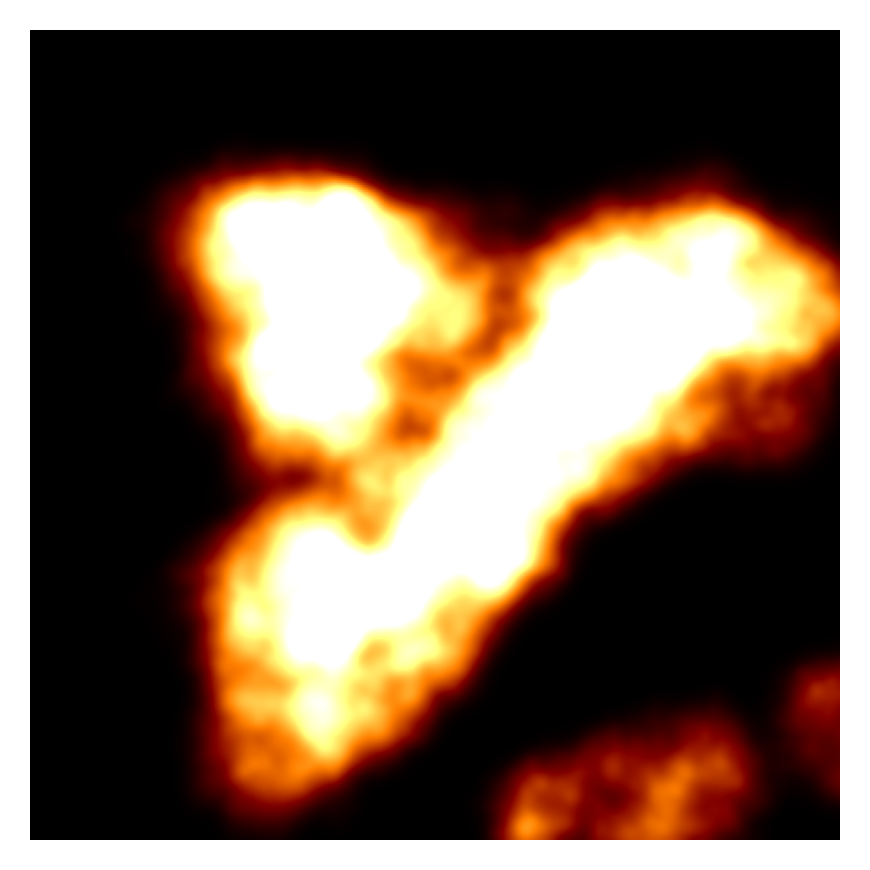

In [17]:
max_fit = np.amax(palm_reconstruction)*0.4

# read mask
'''
directory = 'palm\*'
files = filepull(directory)
mask_files = [file for file in files if "PhaseMask.tif" in file]
mask = tif.imread(mask_files[0])
from skimage.transform import resize
mask_resized = resize(mask, (img.shape[0]*palm_pix_factor,img.shape[1]*palm_pix_factor))
'''
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
plt.axis('off')
palm_reconstruction_blur = filters.gaussian(palm_reconstruction, 1)
plt.imshow(palm_reconstruction_blur, cmap='afmhot', vmin=0,vmax=max_fit) 
#plt.contour(mask_resized, colors='white', linewidths=0.5, levels=[1])
fig.tight_layout()
if saveplot == True:
    tif.imwrite(phaseimg_files[0][:-4] + '_PALM.tif', palm_reconstruction)
    plt.savefig(phaseimg_files[0][:-4] + '_PALM.png',
                    dpi=300, 
                    bbox_inches='tight')
    plt.savefig(phaseimg_files[0][:-4] + '_PALM.svg',
                    dpi=300, 
                    bbox_inches='tight')

if showplot == True:
    plt.show()